In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pytz import timezone
import json

In [89]:
# Load and preprocess data
with open('C:\\Users\\nithy\\NK\\UCD\\Sem3\\SustainbleCityAI\\Backend\\plot_intensity\\co2_intensity_all_2025-07-09_2025-07-11.json', 'r') as file:
    json_data = json.load(file)

time_series = json_data['data']['time_series']
df = pd.DataFrame(time_series)

# Convert to datetime and localize to Ireland timezone
df['timestamp'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
ireland = timezone('Europe/Dublin')
df['timestamp'] = df['timestamp'].dt.tz_localize(ireland)

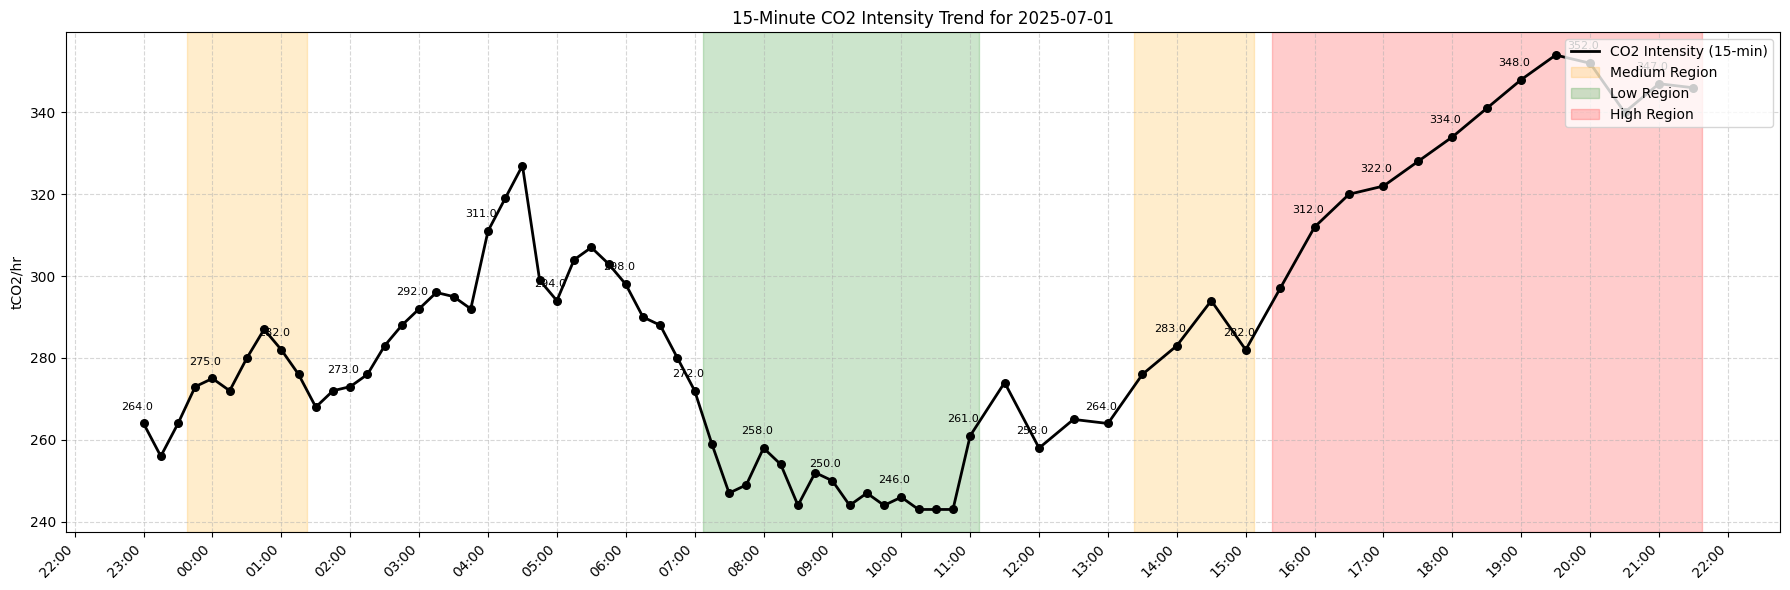

In [10]:
def analyze_daily_intensity(df_):
    """
    Analyzes and visualizes CO2 intensity for a single day using 15-minute data.
    
    Parameters:
    - df_: DataFrame with 'timestamp' and 'value' columns.
    - day: String in 'YYYY-MM-DD' format representing the day to analyze.
    """
    
    df_day = df_.copy()
    

    day_str = df_day["timestamp"].dt.strftime("%Y-%m-%d").iloc[0]

    # Compute thresholds on normalized data
    p33 = np.percentile(df_day["value"], 33)
    p66 = np.percentile(df_day["value"], 66)

    # Categorize function
    def categorize(val):
        if val <= p33:
            return "Low"
        elif val <= p66:
            return "Medium"
        else:
            return "High"

    df_day["category"] = df_day["value"].apply(categorize)

    # Identify consecutive groups with same category
    df_day["group"] = (df_day["category"] != df_day["category"].shift()).cumsum()

    # Plotting
    fig, ax = plt.subplots(figsize=(18, 6))
    
    ax.plot(df_day["timestamp"], df_day["value"], color="black", linewidth=2, label="CO2 Intensity (15-min)")
    ax.scatter(df_day["timestamp"], df_day["value"], color="black", s=30, zorder=3)

    # Color map for categories
    color_map = {"Low": "green", "Medium": "orange", "High": "red"}
    added_to_legend = set()

    # Highlight regions lasting at least 1.5 hours (6 consecutive 15-min intervals)
    for _, group_df in df_day.groupby("group"):
        category = group_df["category"].iloc[0]
        start_time = group_df["timestamp"].iloc[0]
        end_time = group_df["timestamp"].iloc[-1]
        duration_minutes = (end_time - start_time).total_seconds() / 60
        
        if duration_minutes >= 90:  # 1.5 hours
            label = f"{category} Region" if category not in added_to_legend else None
            ax.axvspan(start_time - pd.Timedelta(minutes=7.5),
                       end_time + pd.Timedelta(minutes=7.5),
                       color=color_map[category], alpha=0.2, label=label)
            if label:
                added_to_legend.add(category)

    # X-axis formatting
    ax.xaxis.set_major_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    # ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Value annotations every hour to avoid clutter
    hourly_ticks = df_day[df_day["timestamp"].dt.minute == 0]
    for x, y in zip(hourly_ticks["timestamp"], hourly_ticks["value"]):
        ax.annotate(f"{y:.1f}", (x, y), textcoords="offset points", 
                   xytext=(-5,10), ha='center', fontsize=8)

    ax.set_ylabel("tCO2/hr")
    ax.set_title(f"15-Minute CO2 Intensity Trend for {day_str}")
    ax.legend(loc="upper right")
    ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Call the function with the weekly data
analyze_daily_intensity(df)


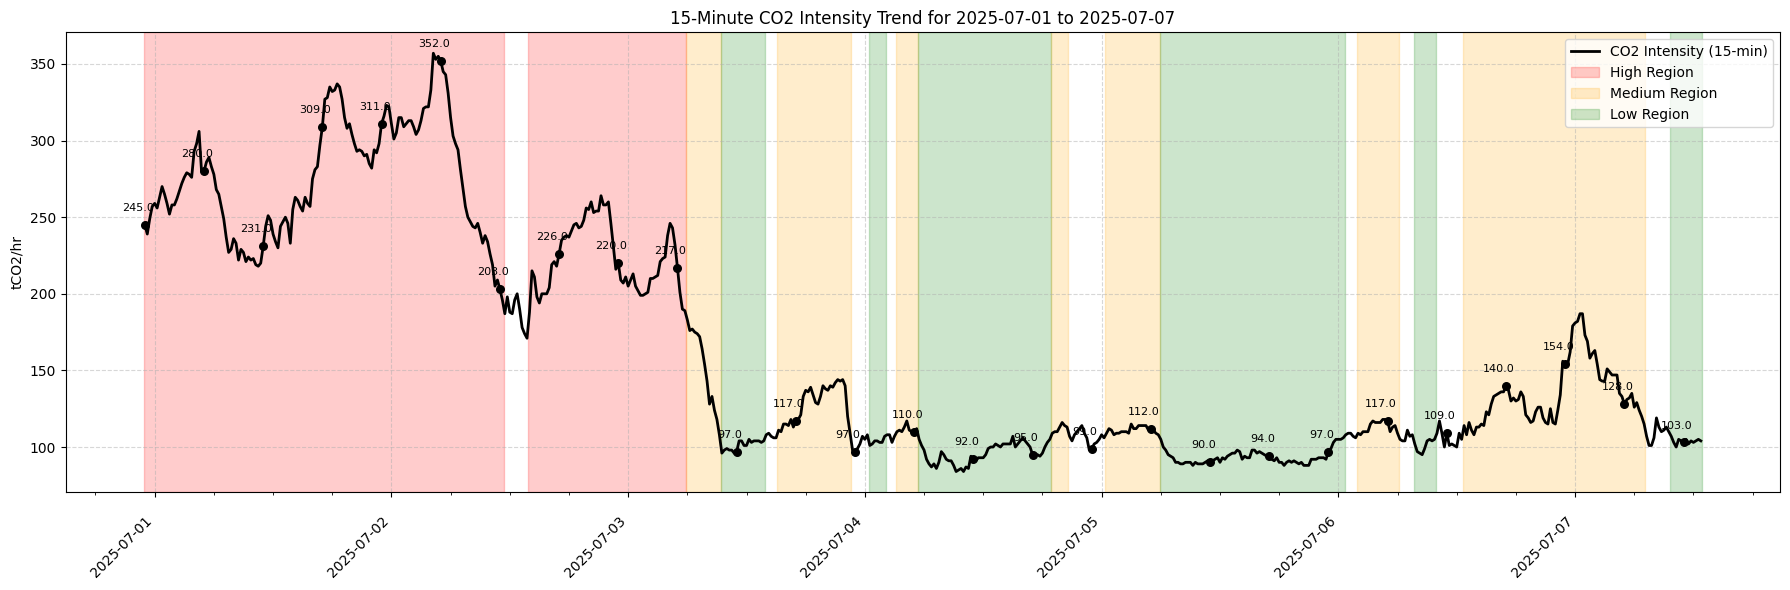

In [17]:
def analyze_intensity(df_, max_days_to_plot=7):
    """
    Analyzes and visualizes CO2 intensity using 15-minute data for one or multiple days.
    
    Parameters:
    - df_: DataFrame with 'timestamp' and 'value' columns.
    - max_days_to_plot: Maximum number of days to plot in a single visualization (default: 7).
                        If data spans more days, it will be split into multiple plots.
    """
    
    df = df_.copy()
    
    # Extract date from timestamp
    df['date'] = df['timestamp'].dt.date
    
    # Get unique days in the data
    unique_days = df['date'].unique()
    num_days = len(unique_days)
    
    # Split into batches if more than max_days_to_plot
    day_batches = [unique_days[i:i + max_days_to_plot] 
                   for i in range(0, num_days, max_days_to_plot)]
    
    for day_batch in day_batches:
        df_batch = df[df['date'].isin(day_batch)].copy()
        
        # Compute thresholds for this batch (normalized across all days in batch)
        p33 = np.percentile(df_batch["value"], 33)
        p66 = np.percentile(df_batch["value"], 66)

        # Categorize function
        def categorize(val):
            if val <= p33:
                return "Low"
            elif val <= p66:
                return "Medium"
            else:
                return "High"

        df_batch["category"] = df_batch["value"].apply(categorize)

        # Identify consecutive groups with same category
        df_batch["group"] = (df_batch["category"] != df_batch["category"].shift()).cumsum()

        # Plotting
        fig, ax = plt.subplots(figsize=(18, 6))
        
        # Plot the line for the full data
        ax.plot(df_batch["timestamp"], df_batch["value"], color="black", linewidth=2, 
                label="CO2 Intensity (15-min)")

        # Color map for categories
        color_map = {"Low": "green", "Medium": "orange", "High": "red"}
        added_to_legend = set()

        # Highlight regions lasting at least 1.5 hours (6 consecutive 15-min intervals)
        for _, group_df in df_batch.groupby("group"):
            category = group_df["category"].iloc[0]
            start_time = group_df["timestamp"].iloc[0]
            end_time = group_df["timestamp"].iloc[-1]
            duration_minutes = (end_time - start_time).total_seconds() / 60
            
            if duration_minutes >= 90:  # 1.5 hours
                label = f"{category} Region" if category not in added_to_legend else None
                ax.axvspan(start_time - pd.Timedelta(minutes=7.5),
                           end_time + pd.Timedelta(minutes=7.5),
                           color=color_map[category], alpha=0.2, label=label)
                if label:
                    added_to_legend.add(category)

        # X-axis formatting
        if len(day_batch) == 1:
            # Single day format
            ax.xaxis.set_major_locator(mdates.HourLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
            date_str = day_batch[0].strftime("%Y-%m-%d")
            title = f"15-Minute CO2 Intensity Trend for {date_str}"
            # Hourly markers and annotations for single day
            annotation_points = df_batch[df_batch["timestamp"].dt.minute == 0]
        else:
            # Multi-day format
            ax.xaxis.set_major_locator(mdates.DayLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%Y-%m-%d"))
            ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0,24,6)))
            date_range_str = f"{day_batch[0].strftime('%Y-%m-%d')} to {day_batch[-1].strftime('%Y-%m-%d')}"
            title = f"15-Minute CO2 Intensity Trend for {date_range_str}"
            # Every 6 hours markers and annotations for multi-day
            annotation_points = df_batch[(df_batch["timestamp"].dt.hour % 6 == 0) & 
                                        (df_batch["timestamp"].dt.minute == 0)]

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

        # Add markers and annotations only at selected points
        ax.scatter(annotation_points["timestamp"], annotation_points["value"], 
                  color="black", s=30, zorder=3)
        
        for x, y in zip(annotation_points["timestamp"], annotation_points["value"]):
            ax.annotate(f"{y:.1f}", (x, y), textcoords="offset points", 
                       xytext=(-5,10), ha='center', fontsize=8)

        ax.set_ylabel("tCO2/hr")
        ax.set_title(title)
        ax.legend(loc="upper right")
        ax.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

# Call the function with the data
analyze_intensity(df)

In [61]:
df['timestamp'] = df['timestamp'].dt.tz_localize(None)
print(df.to_string())

                   time  value  is_forecast           timestamp
0   2025-07-01 00:00:00  264.0        False 2025-07-01 00:00:00
1   2025-07-01 00:15:00  256.0        False 2025-07-01 00:15:00
2   2025-07-01 00:30:00  264.0        False 2025-07-01 00:30:00
3   2025-07-01 00:45:00  273.0        False 2025-07-01 00:45:00
4   2025-07-01 01:00:00  275.0        False 2025-07-01 01:00:00
5   2025-07-01 01:15:00  272.0        False 2025-07-01 01:15:00
6   2025-07-01 01:30:00  280.0        False 2025-07-01 01:30:00
7   2025-07-01 01:45:00  287.0        False 2025-07-01 01:45:00
8   2025-07-01 02:00:00  282.0        False 2025-07-01 02:00:00
9   2025-07-01 02:15:00  276.0        False 2025-07-01 02:15:00
10  2025-07-01 02:30:00  268.0        False 2025-07-01 02:30:00
11  2025-07-01 02:45:00  272.0        False 2025-07-01 02:45:00
12  2025-07-01 03:00:00  273.0        False 2025-07-01 03:00:00
13  2025-07-01 03:15:00  276.0        False 2025-07-01 03:15:00
14  2025-07-01 03:30:00  283.0        Fa

In [91]:
def calculate_thresholds(values):
        q1, q3 = np.percentile(values, [33, 66])
        return {'low': q1, 'high': q3}

def classify_intensity(values: pd.Series, thresholds) -> pd.Series:
    return pd.cut(values,
                 bins=[-np.inf, thresholds['low'], thresholds['high'], np.inf],
                 labels=['low', 'medium', 'high'])

# Calculate thresholds based on processed data
thresholds = calculate_thresholds(df['value'].values)

# Classify intensity 
df['level'] = classify_intensity(df['value'], thresholds)

In [92]:
df.head()

,time,value,is_forecast,forecast_value,timestamp,level
0,2025-07-09 00:00:00,247.0,False,NaN,2025-07-09 00:00:00+01:00,high
1,2025-07-09 00:15:00,247.0,False,NaN,2025-07-09 00:15:00+01:00,high
2,2025-07-09 00:30:00,250.0,False,NaN,2025-07-09 00:30:00+01:00,high
3,2025-07-09 00:45:00,251.0,False,NaN,2025-07-09 00:45:00+01:00,high
4,2025-07-09 01:00:00,247.0,False,NaN,2025-07-09 01:00:00+01:00,high


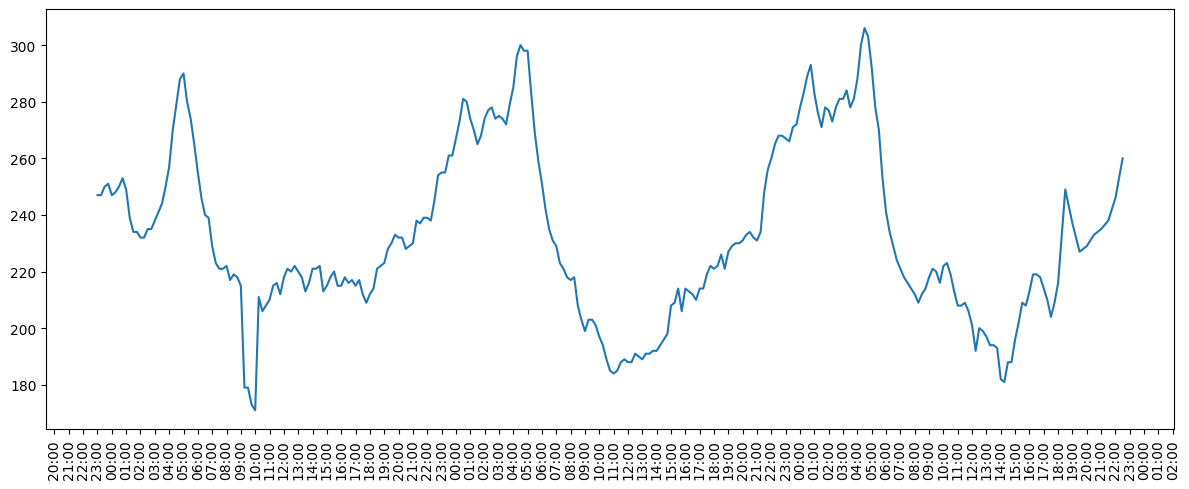

In [93]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['value'], label='Actual')

# Convert to datetime if not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create hourly ticks - this will work regardless of irregular intervals
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Show every hour
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format as hour:minute

plt.xticks(rotation="vertical")
plt.tight_layout()
plt.show()

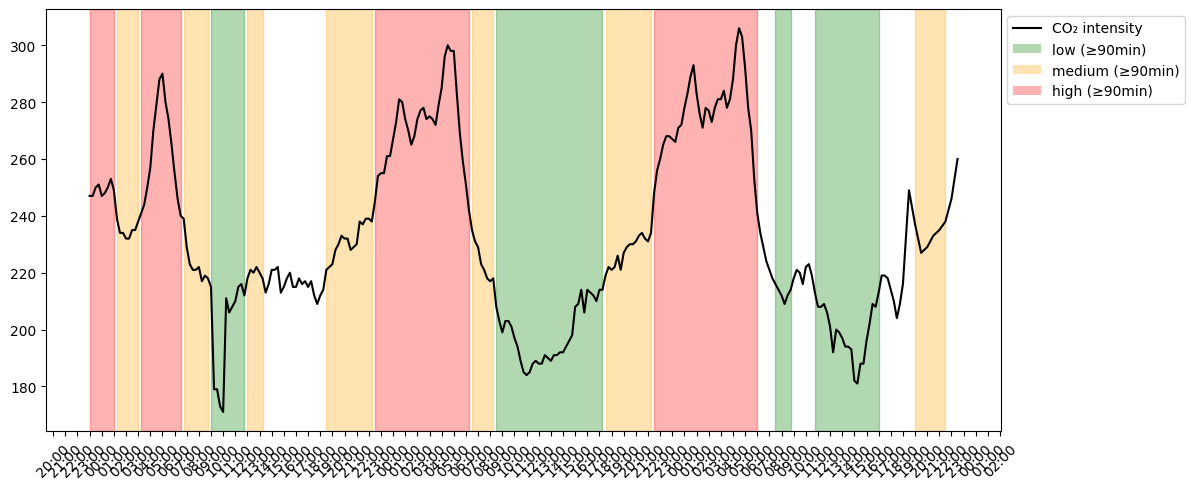

In [94]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap


# Create a column to identify consecutive level groups
df['level_group'] = (df['level'] != df['level'].shift(1)).cumsum()

# Filter groups that last at least 90 minutes (6 intervals)
min_intervals = 6
highlight_regions = df.groupby('level_group').filter(
    lambda x: len(x) >= min_intervals
).groupby('level_group').agg(
    {'timestamp': ['first', 'last'], 'level': 'first'}
).reset_index(drop=True)

# Define colors for each level
level_colors = {
    'low': 'green',
    'medium': 'orange',
    'high': 'red'
}

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['value'], label='Actual', color='black')

# Highlight regions
for _, row in highlight_regions.iterrows():
    plt.axvspan(
        row[('timestamp', 'first')],
        row[('timestamp', 'last')],
        color=level_colors[row['level'].iloc[0]],
        alpha=0.3,
        label=f"{row['level'].iloc[0]} (≥90min)"
    )

# Format x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)

legend_handles = []
legend_labels = []

# Manually create legend entries in desired order
for level, color in [('low', 'green'), ('medium', 'orange'), ('high', 'red')]:
    # Add a dummy patch (rectangle) for each level
    patch = plt.Rectangle((0, 0), 1, 1, fc=color, alpha=0.3, label=level)
    legend_handles.append(patch)
    legend_labels.append(f"{level} (≥90min)")

# Add the actual data line (black) to the legend
line = plt.Line2D([], [], color='black', label='CO₂ intensity')
legend_handles.insert(0, line)  # Insert at the beginning
legend_labels.insert(0, 'CO₂ intensity')

# Apply the custom legend
plt.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()

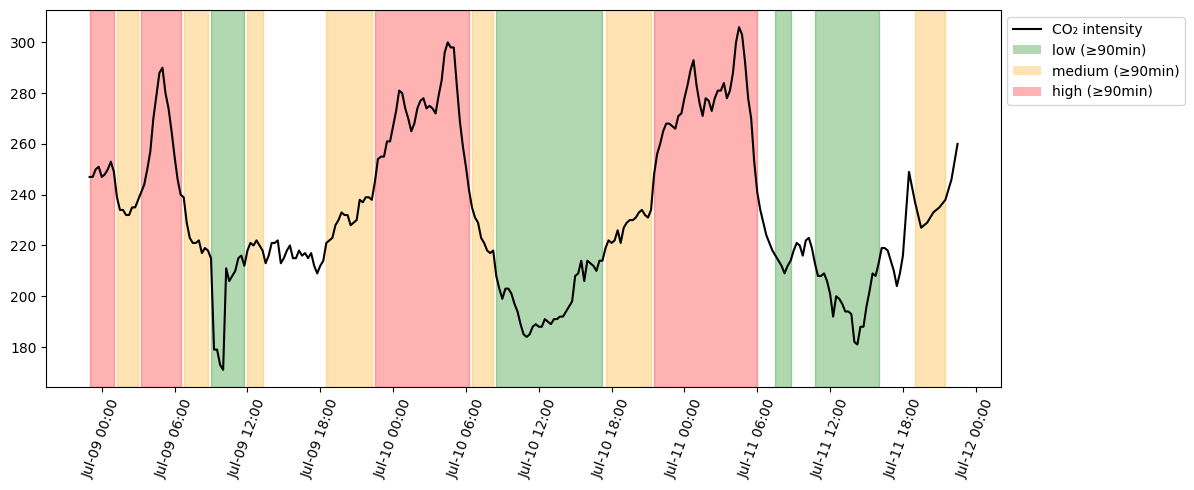

In [105]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap


# Create a column to identify consecutive level groups
df['level_group'] = (df['level'] != df['level'].shift(1)).cumsum()

# Filter groups that last at least 90 minutes (6 intervals)
min_intervals = 6
highlight_regions = df.groupby('level_group').filter(
    lambda x: len(x) >= min_intervals
).groupby('level_group').agg(
    {'timestamp': ['first', 'last'], 'level': 'first'}
).reset_index(drop=True)

# Define colors for each level
level_colors = {
    'low': 'green',
    'medium': 'orange',
    'high': 'red'
}

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['value'], label='Actual', color='black')

# Highlight regions
for _, row in highlight_regions.iterrows():
    plt.axvspan(
        row[('timestamp', 'first')],
        row[('timestamp', 'last')],
        color=level_colors[row['level'].iloc[0]],
        alpha=0.3,
        label=f"{row['level'].iloc[0]} (≥90min)"
    )

# Format x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d %H:%M'))
plt.xticks(rotation=70)

legend_handles = []
legend_labels = []

# Manually create legend entries in desired order
for level, color in [('low', 'green'), ('medium', 'orange'), ('high', 'red')]:
    # Add a dummy patch (rectangle) for each level
    patch = plt.Rectangle((0, 0), 1, 1, fc=color, alpha=0.3, label=level)
    legend_handles.append(patch)
    legend_labels.append(f"{level} (≥90min)")

# Add the actual data line (black) to the legend
line = plt.Line2D([], [], color='black', label='CO₂ intensity')
legend_handles.insert(0, line)  # Insert at the beginning
legend_labels.insert(0, 'CO₂ intensity')

# Apply the custom legend
plt.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()